In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam


In [31]:
def blsc(S, K, T, r, sigma, call=True):
    """
    Black-Scholes option pricing model.
    S: Current stock price
    K: Option strike price
    T: Time to expiration (in years)
    r: Risk-free interest rate
    sigma: Volatility of the underlying asset
    call: True for call option, False for put option
    """
    d1 = (np.log(S / K) + ((r + (0.5 * (sigma ** 2))) * T)) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    
    if call:
        return ((S * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2)))
    else:
        return ((K * np.exp(-r * T) * norm.cdf(-d2)) - (S * norm.cdf(-d1)))

In [32]:
def error(x,y):
        error = np.sum(np.abs(np.array(x) - np.array(y)))*100/np.sum(np.array(y))
        return error

In [33]:
def aggregate(data, size=1):
    return np.array([np.mean(data[i:i + size]) for i in range(0, len(data), size)])

In [34]:
df = pd.read_csv('nvda_options_data.csv')
df = df.dropna()

In [35]:
def algo():
    y_blsc = blsc(df['Stock_Price'], df['strike'], df['Time_to_Expire'], df['Risk_Free_Rate'], df['IV'], call=True)
    loss = error(y_blsc,df['CallPrice'])
    print('Loss:',loss)
    
     # Plot the average results
    plt.figure(figsize=(20, 12))
    plt.plot(aggregate(pd.DataFrame(y_blsc)), label='Predicted', marker='o', linestyle='-', color='blue')
    plt.plot(aggregate(df['CallPrice']), label='Actual (Mean)', marker='s', linestyle='-', color='red')
    plt.title('Mean Predicted vs Actual Values')
    plt.xlabel('Chunk Index')
    plt.ylabel('Mean Value')
    plt.grid()
    plt.legend()
    plt.show()
    return y_blsc

Loss: 6.2211221613320475


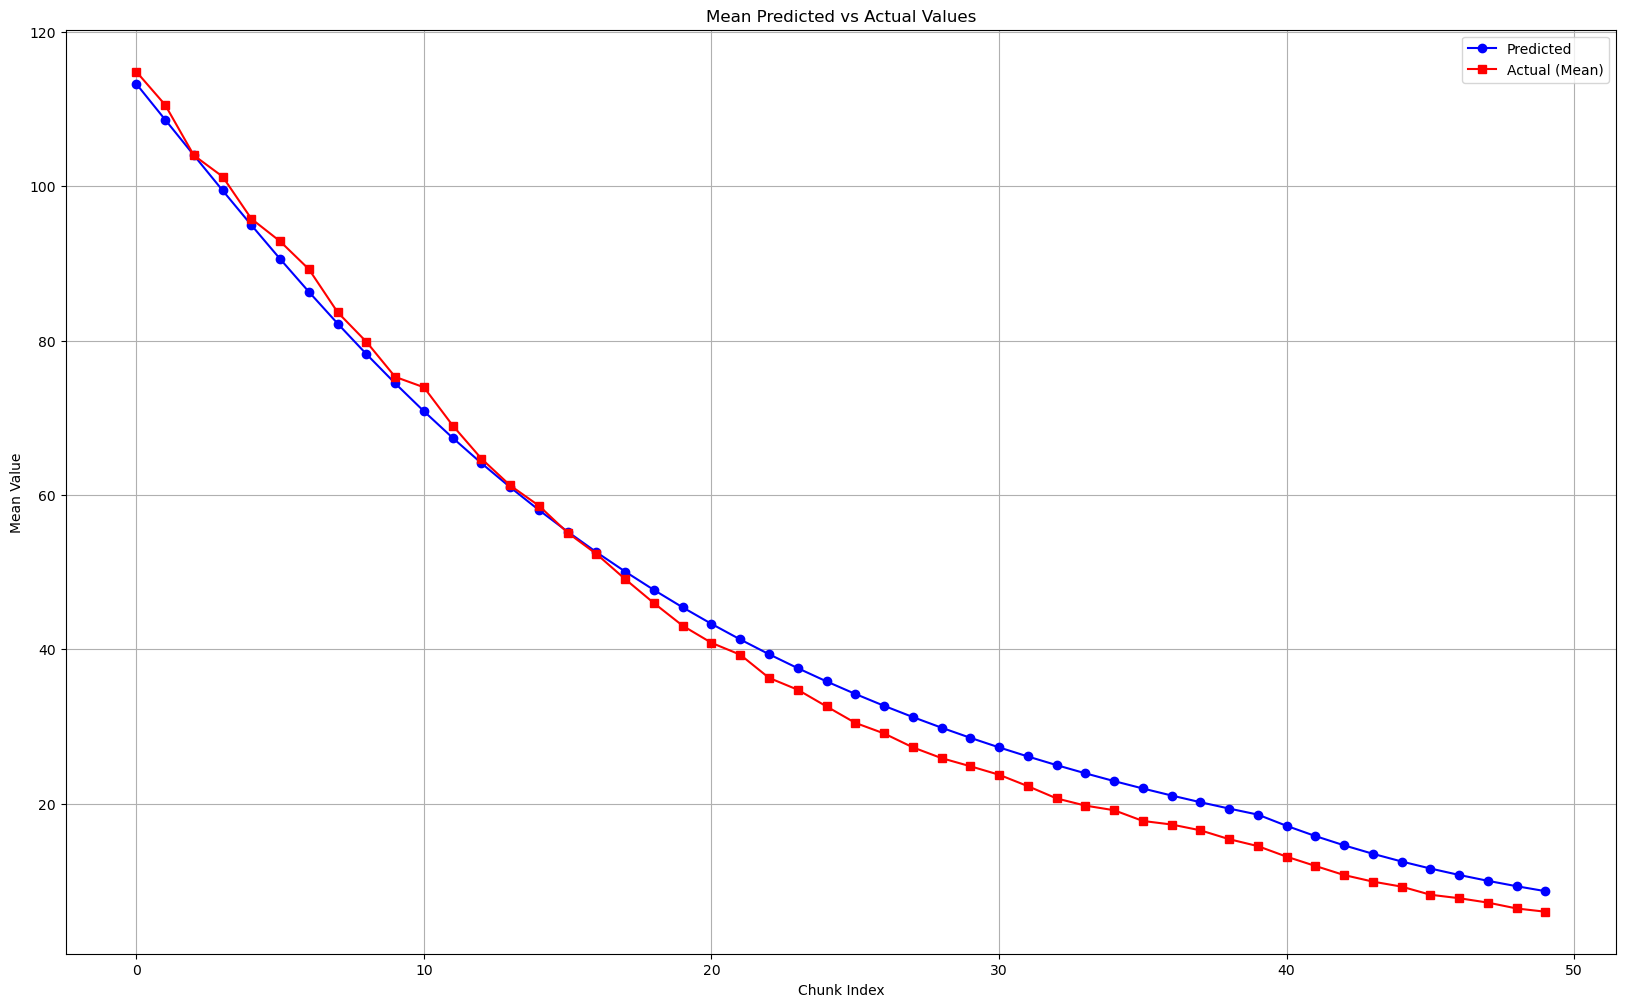

In [36]:
blsc_price = algo()

In [37]:
df['blsc_price'] = blsc_price

In [38]:
X = df[['strike', 'IV','Stock_Price', 'Time_to_Expire','Risk_Free_Rate','blsc_price']]
y = df[['CallPrice']]
X.head()

,strike,IV,Stock_Price,Time_to_Expire,Risk_Free_Rate,blsc_price
0,5.0,0.566315,117.889999,1.820671,0.0422,113.259815
1,10.0,0.566315,117.889999,1.820671,0.0422,108.632243
2,15.0,0.566315,117.889999,1.820671,0.0422,104.021540
3,20.0,0.566315,117.889999,1.820671,0.0422,99.454637
4,25.0,0.566315,117.889999,1.820671,0.0422,94.962941


In [39]:
X.head()

,strike,IV,Stock_Price,Time_to_Expire,Risk_Free_Rate,blsc_price
0,5.0,0.566315,117.889999,1.820671,0.0422,113.259815
1,10.0,0.566315,117.889999,1.820671,0.0422,108.632243
2,15.0,0.566315,117.889999,1.820671,0.0422,104.021540
3,20.0,0.566315,117.889999,1.820671,0.0422,99.454637
4,25.0,0.566315,117.889999,1.820671,0.0422,94.962941


In [40]:
print(f"X shape: {X.shape}, Y shape: {y.shape}")    

X shape: (50, 6), Y shape: (50, 1)


In [41]:
X = StandardScaler().fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)

In [43]:
X_train, y_train = tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test, y_test = tf.convert_to_tensor(X_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [44]:
# Hyperparams
n_units = X_train.shape[1]
n1_units = 400
layers = 4

In [45]:
model = Sequential()
model.add(Dense(n_units, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
for _ in range(layers - 1):
    model.add(Dense(n1_units))
    model.add(LeakyReLU())

model.add(Dense(1, activation='relu'))

/Users/aadityatrivedee/tf_lib/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 400)            │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,043 (1.24 MB)

 Trainable params: 324,043 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))

In [48]:
batch_size = 32
losses = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=batch_size, epochs=30, verbose=1)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 43.5256 - val_loss: 39.6543
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 43.2403 - val_loss: 38.9783
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 42.8744 - val_loss: 37.9395
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 40.9056 - val_loss: 36.3397
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 38.4437 - val_loss: 33.9855
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 37.0492 - val_loss: 30.8307
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 34.9449 - val_loss: 27.7252
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 33.2288 - val_loss: 24.0686
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 27.1228 - val_loss: 19.3980
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 21.6728 - val_loss: 13.2119
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 14.0384 - val_loss: 8.9930
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.327

In [49]:
model.evaluate(X_test[:3], y_test[:3],batch_size=batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5523


0.5523300170898438

In [50]:
model.predict(pd.DataFrame(X_test).iloc[0:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[ 17.95041 ],
       [ 33.037785],
       [ 10.468796],
       [ 36.12249 ],
       [  8.433231],
       [  9.392245],
       [ 14.417397],
       [ 66.097595],
       [ 96.46638 ],
       [113.41064 ]], dtype=float32)

In [51]:
pd.DataFrame(y_test).iloc[0:10]

,0
0,17.299999
1,32.599998
2,9.900000
3,36.299999
4,8.200000
5,9.250000
6,13.130000
7,64.699997
8,95.779999
9,114.839996


<Axes: >

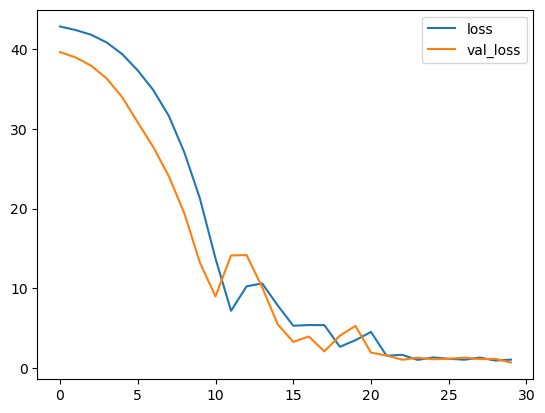

In [52]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()

In [53]:
def model_error(x,y):
    error = np.sum(np.abs(model.predict(pd.DataFrame(x)) - pd.DataFrame(y)))*100/(np.sum(np.array(y)))
    return error
print('Mean Square Percentage Error in train:', model_error(X_train, y_train))
print('Mean Square Percentage Error in test:', model_error(X_test, y_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Mean Square Percentage Error in train: 0    1.654118
dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Mean Square Percentage Error in test: 0    1.743959
dtype: float32


/Users/aadityatrivedee/tf_lib/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/aadityatrivedee/tf_lib/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


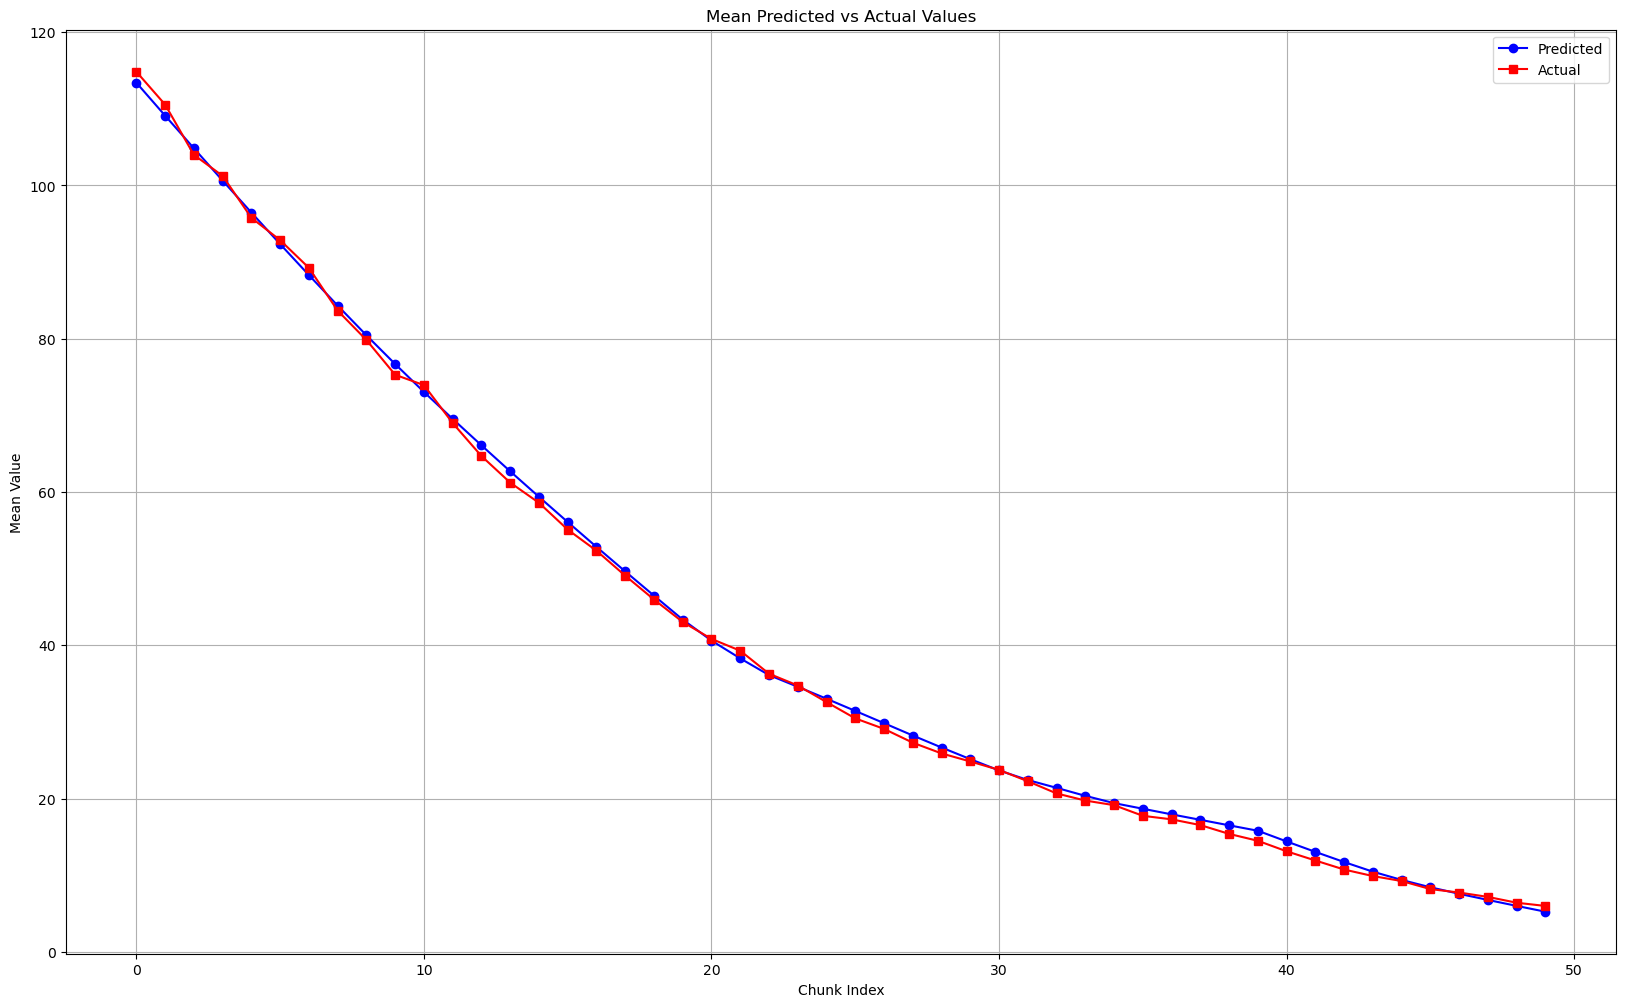

In [54]:
plt.figure(figsize=(20, 12))
X_plt=model.predict(pd.DataFrame(X))
plt.plot(aggregate(X_plt), label='Predicted', marker='o', linestyle='-', color='blue')
plt.plot(aggregate(pd.DataFrame(y)), label='Actual', marker='s', linestyle='-', color='red')
plt.title('Mean Predicted vs Actual Values')
plt.xlabel('Chunk Index')
plt.ylabel('Mean Value')
plt.grid()
plt.legend()
plt.show()

In [55]:
model.save('hybrid_call.h5')